<a href="https://colab.research.google.com/github/sxqqslf/TensorflowDaily/blob/master/MLAtProductionScale/TestClassifierTFHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --quiet "tensorflow>=1.7"
!pip install -q tensorflow-hub
!pip install -q seaborn

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [4]:
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_dataset(force_download=False):
  dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz", 
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
    extract=True)
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), "aclImdb", "test"))
  
  return train_df, test_df

train_df, test_df = download_and_load_dataset()
train_df.head()

84131840/84125825 [==============================] - 8s 0us/step


,sentence,sentiment,polarity
0,A DOUBLE LIFE has developed a mystique among f...,8,1
1,A surprisingly good movie! It has quite a few ...,7,1
2,"In The White Balloon and Crimson Gold, the two...",7,1
3,"In his 1966 film ""Blow Up"", Antonioni had his ...",3,0
4,"Flat, ordinary thriller about a conniving woma...",4,0


In [0]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(
  train_df, train_df["polarity"], num_epochs=None, shuffle=True)

predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
  train_df, train_df["polarity"], shuffle=False)

predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
  test_df, test_df["polarity"], shuffle=False)

In [5]:
embedded_text_feature_column = hub.text_embedding_column(
  key="sentence",
  module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.


In [7]:
estimator = tf.estimator.DNNClassifier(
  hidden_units=[500, 100],
  feature_columns=[embedded_text_feature_column], 
  n_classes=2,
  optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpcg_3xye_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f71a6749f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
estimator.train(input_fn=train_input_fn, steps=1000)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcg_3xye_/model.ckpt.
INFO:tensorflow:loss = 90.57274, step = 1
INFO:tensorflow:global_step/sec: 35.4632
INFO:tensorflow:loss = 62.67977, step = 101 (2.826 sec)
INFO:tensorflow:global_step/sec: 32.5093
INFO:tensorflow:loss = 54.696304, step = 201 (3.075 sec)
INFO:tensorflow:global_s

In [11]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-13-07:57:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcg_3xye_/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-13-07:57:23
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.80112, accuracy_baseline = 0.5, auc = 0.8839908, auc_precision_recall = 0.88347405, average_loss = 0.42893434, global_step = 1000, label/mean = 0.5, loss = 54.711014, precision = 0.8050243, prediction/mean = 0.49726617, recall = 0.79472
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpcg_3xye_/model.ckpt-1000
INFO:tensorflow:Calling model_fn

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcg_3xye_/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0

Text(51,0.5,'True')

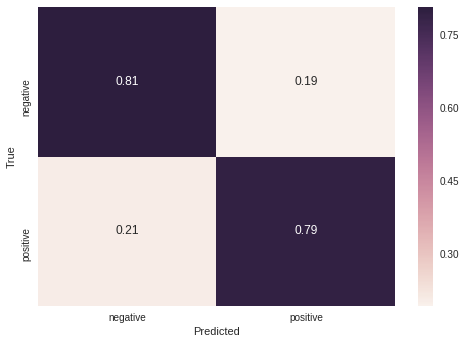

In [16]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]


print(get_predictions(estimator, predict_train_input_fn))

LABELS=[
    "negative", "positive"
]

with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"],
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)
    
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

In [0]:
def train_and_evaluate_with_model(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", module_spec=hub_module, trainable=train_module)
  
  estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))
  
  estimator.train(input_fn=train_input_fn, steps=1000)
  
  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
  
  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]
  
  return {
      "Training accuracy" : training_set_accuracy,
      "Test accuracy" : test_set_accuracy
  }

results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_model(
  "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_model(
  "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_model(
  "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-modult-training"] = train_and_evaluate_with_model(
  "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

pd.DataFrame.from_dict(results, orient="index")

In [0]:
estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]